In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from sklearn.preprocessing import StandardScaler

from torchcp.regression.predictors import SplitPredictor,CQR
from torchcp.regression.loss import QuantileLoss 
from torchcp.utils import fix_randomness
from examples.common.dataset import build_reg_data
from examples.common.utils import build_regression_model
from tqdm import tqdm

In [2]:
def train(model, device, epoch, train_data_loader, criterion, optimizer):
    for index, (tmp_x, tmp_y) in enumerate(train_data_loader):
        outputs = model(tmp_x.to(device))
        loss = criterion(outputs, tmp_y.unsqueeze(dim=1).to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
fix_randomness(seed=1)
X, y = build_reg_data('synthetic')
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
split_index1 = int(len(indices) * 0.4)
split_index2 = int(len(indices) * 0.6)
part1, part2, part3 = np.split(indices, [split_index1, split_index2])
scalerX = StandardScaler()
scalerX = scalerX.fit(X[part1, :])
train_dataset = TensorDataset(torch.from_numpy(scalerX.transform(X[part1, :])), torch.from_numpy(y[part1]))
cal_dataset = TensorDataset(torch.from_numpy(scalerX.transform(X[part2, :])), torch.from_numpy(y[part2]))
test_dataset = TensorDataset(torch.from_numpy(scalerX.transform(X[part3, :])), torch.from_numpy(y[part3]))

train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True, pin_memory=True)
cal_data_loader = torch.utils.data.DataLoader(cal_dataset, batch_size=100, shuffle=False, pin_memory=True)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, pin_memory=True)

epochs = 100
alpha = 0.1

In [4]:
print(y.shape)

(5000,)


In [5]:
print(y)

[16.852205  9.38944  20.02394  ...  8.830095 11.091218 20.64594 ]


In [6]:
##################################
# Split Conformal Prediction
##################################
print("########################## SplitPredictor ###########################")
model = build_regression_model("NonLinearNet")(X.shape[1], 1, 64, 0.5).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(epochs):
    train(model, device, epoch, train_data_loader, criterion, optimizer)

model.eval()
predictor = SplitPredictor(model)
predictor.calibrate(cal_data_loader, alpha)
print(predictor.evaluate(test_data_loader))
y_pre = []
for batch_idx, (data, target) in tqdm(enumerate(test_data_loader)):
    prediction_Intervals = predictor.predict(data.to(device))
    for i in range(len(prediction_Intervals)):
        y_pre.append(prediction_Intervals[i][0].item())

########################## SplitPredictor ###########################
{'Coverage_rate': 0.9000000357627869, 'Average_size': 10.862747192382812}


20it [00:00, 439.66it/s]


In [7]:
##################################
# Conformal Quantile Regression
##################################
print("########################## CQR ###########################")


quantiles = [alpha / 2, 1 - alpha / 2]
model = build_regression_model("NonLinearNet")(X.shape[1], 2, 64, 0.5).to(device)
criterion = QuantileLoss(quantiles)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(epochs):
    train(model, device, epoch, train_data_loader, criterion, optimizer)

model.eval()
predictor = CQR(model)
predictor.calibrate(cal_data_loader, alpha)
print(predictor.evaluate(test_data_loader))

########################## CQR ###########################
{'Coverage_rate': 0.9010000228881836, 'Average_size': 11.128320693969727}


In [8]:
y_up = []
y_low = []
for batch_idx, (data, target) in tqdm(enumerate(test_data_loader)):
    prediction_Intervals = predictor.predict(data)
    for i in range(len(prediction_Intervals)):
        y_low.append(prediction_Intervals[i][0].item())
        y_up.append(prediction_Intervals[i][1].item())

20it [00:00, 204.78it/s]


In [9]:
len(y_up)

2000

In [10]:
y_truth = y[-2000:]

In [11]:
len(y_truth)

2000

In [17]:
len(y_truth)

2000

In [13]:
test_X = X[-2000:]

In [14]:
len(test_X[0])

5

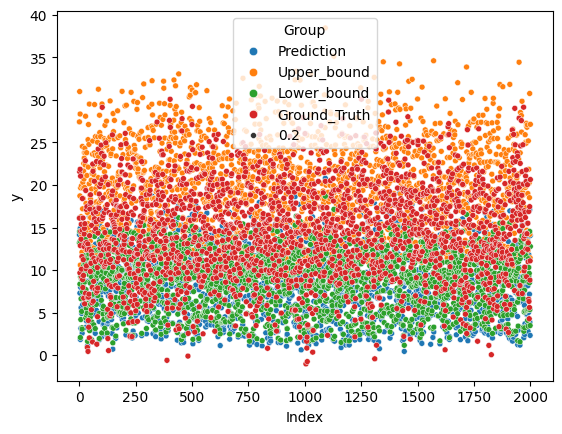

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 创建一个x值列表，从1到200
x_data = np.arange(1, 2001)

# 将数据构造成DataFrame
df_list = [
    pd.DataFrame({'x': x_data, 'y': y_pre, 'group': 'Prediction'}),
    pd.DataFrame({'x': x_data, 'y': y_up, 'group': 'Upper_bound'}),
    pd.DataFrame({'x': x_data, 'y': y_low, 'group': 'Lower_bound'}),
    pd.DataFrame({'x': x_data, 'y': y_truth, 'group': 'Ground_Truth'})
]

# 合并所有数据
df = pd.concat(df_list)

# 使用seaborn画散点图
sns.scatterplot(data=df, x='x', y='y', hue='group', size=0.2)

plt.xlabel('Index')
plt.ylabel('y')
plt.legend(title='Group')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
# 创建一个x值数组，从1到200
x_data = np.arange(1, 2001)

# 绘制每组数据的线图
plt.figure(figsize=(10, 12))

# 第一组数据
plt.plot(x_data, y_pre, label='Prediction', linewidth=2)
# 第二组数据
plt.plot(x_data, y_up, label='Upper_bound', linewidth=2)
# 第三组数据
plt.plot(x_data, y_low, label='Lower_bound', linewidth=2)
# 第四组数据
plt.plot(x_data, y_truth, label='Ground_truth', linewidth=2)

plt.xlabel('Index')
plt.ylabel('y')
plt.legend(title='Group')
plt.grid(True)  # 添加网格线以增强可读性
plt.xlim(0, 2001)  # 设置x轴范围
plt.xticks(np.arange(0, 2001, step=20))  # 可选：设置x轴刻度标签间隔
plt.show()